# Polt the Anomaly Detection Result

## 1. Import

In [1]:
import requests
import datetime
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import datetime
import json
import time
import math

## 2. Setup Env Var
**\_\_AIOTCORE\_\_ is the aiot-core publice interface's IP address of aiot-core container.**

In [4]:
__AIOTCORE__="http://127.0.0.1:9250"

## 3. Plot

[{'count': '18.090486228499998', 'entity_id': 'urn:Temp:SG_Artifical:Sensor01', 'entity_type': 'Sensor', 'fiware_servicepath': '/', 'time_index': 1396310400000, 'timestamp': 1396310400000}, {'count': '20.359842585899997', 'entity_id': 'urn:Temp:SG_Artifical:Sensor01', 'entity_type': 'Sensor', 'fiware_servicepath': '/', 'time_index': 1396310700000, 'timestamp': 1396310700000}, {'count': '21.105469847200002', 'entity_id': 'urn:Temp:SG_Artifical:Sensor01', 'entity_type': 'Sensor', 'fiware_servicepath': '/', 'time_index': 1396311000000, 'timestamp': 1396311000000}, {'count': '21.1515852522', 'entity_id': 'urn:Temp:SG_Artifical:Sensor01', 'entity_type': 'Sensor', 'fiware_servicepath': '/', 'time_index': 1396311300000, 'timestamp': 1396311300000}, {'count': '18.1371405424', 'entity_id': 'urn:Temp:SG_Artifical:Sensor01', 'entity_type': 'Sensor', 'fiware_servicepath': '/', 'time_index': 1396311600000, 'timestamp': 1396311600000}, {'count': '21.6256605306', 'entity_id': 'urn:Temp:SG_Artifical:S

KeyError: 'anomalyflag'

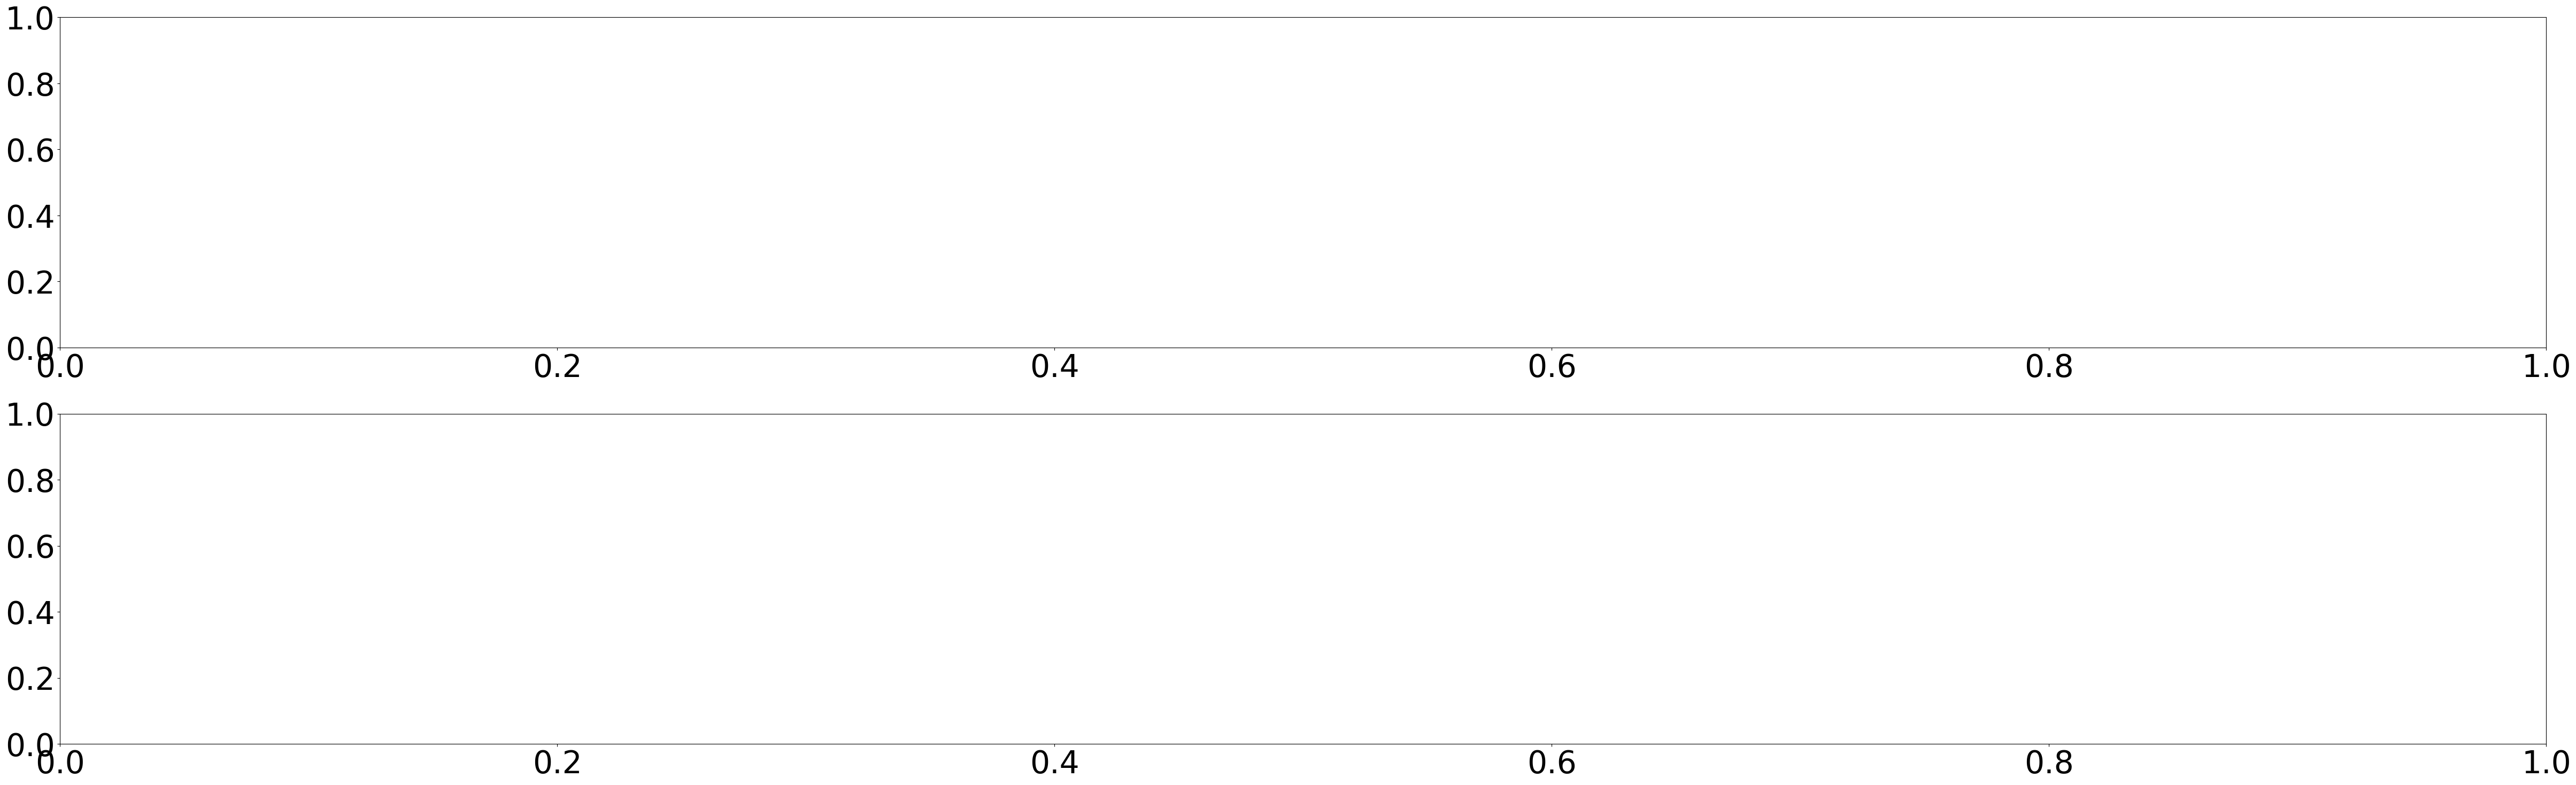

In [9]:
with open("../../Dataset/NAB/combined_windows.json","r") as f:
    labels=json.load(f)
service_group=requests.get(f"{__AIOTCORE__}/service-groups").json()['value']
for SG in service_group:
    devices=requests.get(f"{__AIOTCORE__}/service-groups/{SG}").json()["Device"]
    for DeviceName in devices:
        url=f"{__AIOTCORE__}/devices/{SG}/{DeviceName}"
        data=requests.get(url).json()
        fieldName=data["static_attributes"]["fieldName"]
        i=f"{SG}/{DeviceName}"
        for gt in labels:
            if fieldName in gt:
                markAnomaly=labels[gt]
                break
    count=0
    value_array=[]
    prediction_array=[]
    anomaly_likehood_array=[]
    log_anomaly_likehood_array=[]
    anomaly_score_array=[]
    timestamp_array=[]
    anomaly_timeslice=[]
    markAnomalyTimeList=[]
    markerList=[]
    this=0
    r=requests.get(__AIOTCORE__+"/devices/"+i+"/data").json()
    r.reverse()
    fig=plt.figure(figsize=(60,18), dpi= 100, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': 42})
    ax = plt.subplot(211)
    bx = plt.subplot(212,sharex=ax)
    for data in r:
        if data["anomalyflag"]==None:
            continue
        value=float(data["count"])
        value_array.append(value)
        prediction_array.append(float(data["predictionvalue"]))
        anomaly_likehood_array.append(float(data["rawanomalylikehood"]))
        logamolikehood=float(data["anomalyscore"])
        timestamp = (datetime.timedelta(
                        seconds=data["timestamp"]/1000)+datetime.datetime(1970, 1, 1))
        timestamp_array.append(timestamp)
        log_anomaly_likehood_array.append(logamolikehood)
        if data["anomalyflag"]:
            markerList.append([timestamp,value,logamolikehood])
    maxVal=max(value_array)
    minVal=min(value_array)
    maxLog=max(log_anomaly_likehood_array)
    minLog=min(log_anomaly_likehood_array)
    

    ax.set_ylabel("Value")
    markers=["X"]
    colors=["red"]
    m=0
    
    ax.set_ylim([minVal-0.05*(maxVal-minVal),maxVal+0.05*(maxVal-minVal)])
    for timestamp in timestamp_array:
        for mark in markAnomaly:
            startTime=datetime.datetime.strptime(mark[0],"%Y-%m-%d %H:%M:%S.000000")
            endTime=datetime.datetime.strptime(mark[1],"%Y-%m-%d %H:%M:%S.000000")
            if timestamp>=startTime and timestamp<=endTime:
                markAnomalyTimeList.append(timestamp)
    ax.bar(markAnomalyTimeList,height=maxVal,bottom=minVal,width=0.1,color="sandybrown",zorder=-10,align='edge')
    ax.plot(timestamp_array,value_array,color="blue",linewidth=2,zorder=-5)
    bx.bar(markAnomalyTimeList,height=1,bottom=0,width=0.1,color="sandybrown",zorder=-10,align='edge')
    bx.plot(timestamp_array,log_anomaly_likehood_array,color="Black",linewidth=3.0,zorder=15)
    for key in markerList:
        ax.plot(key[0],key[1],linewidth=0,marker=markers[m],markerSize=45,zorder=5,color=colors[m],alpha=0.7)
    for key in markerList:
        bx.plot(key[0],key[2],linewidth=0,marker=markers[m],markerSize=45,zorder=5,color=colors[m],alpha=0.7)
    bx.set_ylim([0,1])
    bx.set_ylabel("Log Anomaly LikeliHood")
    plt.tight_layout()
    plt.grid()
    plt.show()
    plt.savefig(outputTarget+"/"+i.replace("/","_")+".png")
    print("Created")
    plt.close()